In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

from dask.diagnostics import ProgressBar
ProgressBar().register()

MERRA-2 only unique interpolated locations

In [2]:
wt_mer_gwa = pd.read_csv('/data/users/kgruber/other-data/USA/turbine_data_mer_gwa.csv',parse_dates=['commissioning'])
data_mer = xr.open_dataset("/data/users/kgruber/Data/MERRA/USA/merra2_wind_USA_200012.nc")
# Create dataframe with sequence the size of MERRA-2 grid to find out which turbines interpolate to the same point
in_seq = xr.Dataset({'x':(['lat','lon'],
                          np.array(range(data_mer.DISPH.isel(time=0).values.size)).reshape(data_mer.DISPH.isel(time=0).values.shape))},
                     coords = {'lat':data_mer.lat.values,
                               'lon':data_mer.lon.values})

In [3]:
ip = in_seq.interp(coords={"lon":xr.DataArray(wt_mer_gwa.lon,dims='location'),
                           "lat":xr.DataArray(wt_mer_gwa.lat,dims='location')},method="nearest").to_dataframe()

In [4]:
ip['capacity'] = wt_mer_gwa.capacity
ip['sp'] = wt_mer_gwa.sp
ip['height'] = wt_mer_gwa.height

In [5]:
uniques = ip.groupby(ip.x).min()


In [6]:
wind = xr.open_mfdataset("/data/users/kgruber/Data/MERRA/USA/eff_ws/merra2_wind_USA_*.nc", chunks = {'time': 38})

In [7]:
alpha = xr.open_mfdataset("/data/users/kgruber/Data/MERRA/USA/eff_ws/merra2_alpha_USA_*.nc", chunks = {'time': 38})

In [8]:
wh = wind.interp(coords={"lon":xr.DataArray(uniques.lon,dims='location'),
                    "lat":xr.DataArray(uniques.lat,dims='location')},method="nearest")

In [9]:
alphai = alpha.interp(coords={"lon":xr.DataArray(uniques.lon,dims='location'),
                              "lat":xr.DataArray(uniques.lat,dims='location')},method="nearest")

In [10]:
windhh = (wh.wh50 * (80/50)**alphai.alpha)

In [11]:
c_mer = np.corrcoef(windhh,rowvar=False)

[########################################] | 100% Completed |  3min 54.3s


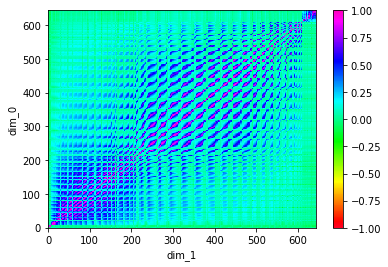

In [14]:
xr.DataArray(c_mer).plot(cmap='gist_rainbow')

## 1 year (2018) vs 18 years

In [18]:
c_mer2018 = np.corrcoef(windhh.sel(time='2018'),rowvar=False)

[########################################] | 100% Completed |  2.1s


(array([   156.,   1622.,  12358.,  66408., 145382., 123574.,  50670.,
         12678.,   1704.,    184.]),
 array([-0.14727907, -0.11788425, -0.08848943, -0.05909462, -0.0296998 ,
        -0.00030499,  0.02908983,  0.05848465,  0.08787946,  0.11727428,
         0.14666909]),
 <a list of 10 Patch objects>)

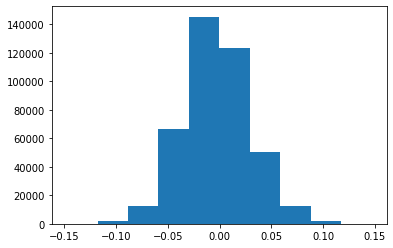

In [30]:
plt.hist((c_mer2018-c_mer).flatten())

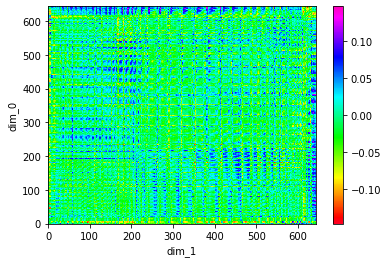

In [20]:
xr.DataArray(c_mer2018-c_mer).plot(cmap='gist_rainbow')

## 1 year (2017) vs 18 years

In [35]:
c_mer2017 = np.corrcoef(windhh.sel(time='2017'),rowvar=False)

[########################################] | 100% Completed |  1.8s


(array([   910.,   3132.,   9492.,  25102.,  80442., 158502., 106954.,
         25728.,   4180.,    294.]),
 array([-0.17773497, -0.14278217, -0.10782937, -0.07287656, -0.03792376,
        -0.00297096,  0.03198185,  0.06693465,  0.10188746,  0.13684026,
         0.17179306]),
 <a list of 10 Patch objects>)

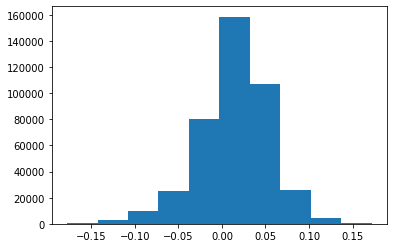

In [36]:
plt.hist((c_mer2017-c_mer).flatten())

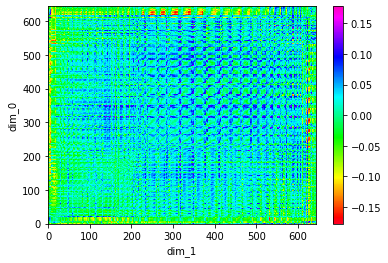

In [37]:
xr.DataArray(c_mer2017-c_mer).plot(cmap='gist_rainbow')

## 1 year (2010) vs 18 years

In [39]:
c_mer2010 = np.corrcoef(windhh.sel(time='2010'),rowvar=False)

[########################################] | 100% Completed |  1.8s


(array([1.4200e+02, 2.4700e+03, 2.0512e+04, 8.2078e+04, 1.5518e+05,
        1.1703e+05, 3.1774e+04, 4.6900e+03, 8.0000e+02, 6.0000e+01]),
 array([-0.18723267, -0.14946038, -0.1116881 , -0.07391582, -0.03614353,
         0.00162875,  0.03940104,  0.07717332,  0.1149456 ,  0.15271789,
         0.19049017]),
 <a list of 10 Patch objects>)

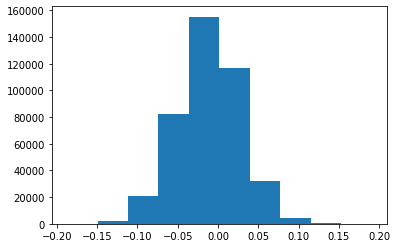

In [40]:
plt.hist((c_mer2010-c_mer).flatten())

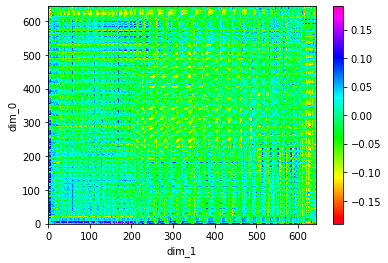

In [41]:
xr.DataArray(c_mer2010-c_mer).plot(cmap='gist_rainbow')

## 9 (2010-2018) years vs 18 years

In [23]:
cor_mer2010_18 = np.corrcoef(windhh.sel(time=np.arange('2010-01-01','2019-01-01', dtype='datetime64[h]')),rowvar=False)

[########################################] | 100% Completed | 17.2s


(array([3.60000e+01, 2.48000e+02, 1.64600e+03, 1.15700e+04, 5.74460e+04,
        1.46714e+05, 1.42154e+05, 4.82740e+04, 6.34200e+03, 3.06000e+02]),
 array([-0.05349713, -0.04455879, -0.03562045, -0.02668212, -0.01774378,
        -0.00880544,  0.0001329 ,  0.00907124,  0.01800957,  0.02694791,
         0.03588625]),
 <a list of 10 Patch objects>)

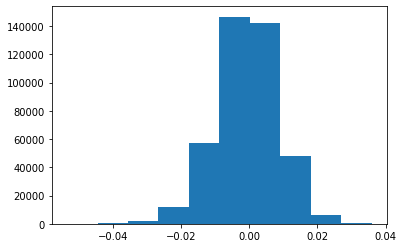

In [28]:
plt.hist((cor_mer2010_18-c_mer).flatten())

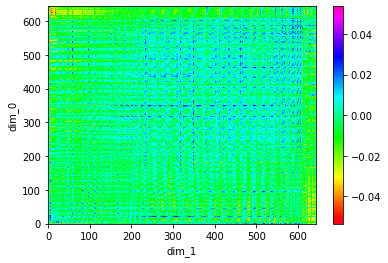

In [26]:
xr.DataArray(cor_mer2010_18-c_mer).plot(cmap='gist_rainbow')

## 4 (2015-2018) years vs 18 years

In [31]:
c_mer2015_18 = np.corrcoef(windhh.sel(time=np.arange('2015-01-01','2019-01-01', dtype='datetime64[h]')),rowvar=False)

[########################################] | 100% Completed |  7.1s


(array([1.04000e+02, 1.25000e+03, 8.16600e+03, 3.47260e+04, 9.97960e+04,
        1.55298e+05, 8.89120e+04, 2.23180e+04, 4.01000e+03, 1.56000e+02]),
 array([-0.08269913, -0.06773982, -0.05278052, -0.03782121, -0.0228619 ,
        -0.0079026 ,  0.00705671,  0.02201602,  0.03697532,  0.05193463,
         0.06689394]),
 <a list of 10 Patch objects>)

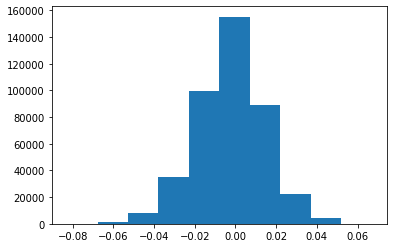

In [33]:
plt.hist((c_mer2015_18-c_mer).flatten())

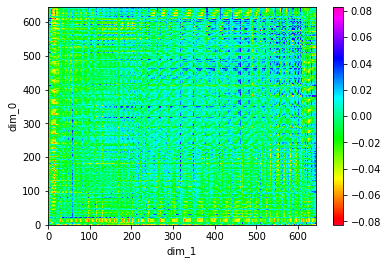

In [34]:
xr.DataArray(c_mer2015_18-c_mer).plot(cmap='gist_rainbow')

## 1 year (2017) vs 1 year (2018)

(array([1.14000e+02, 1.33000e+03, 2.00900e+04, 8.25200e+04, 1.65064e+05,
        1.02654e+05, 3.25740e+04, 8.19400e+03, 2.02600e+03, 1.70000e+02]),
 array([-0.24356984, -0.19511608, -0.14666232, -0.09820856, -0.0497548 ,
        -0.00130104,  0.04715273,  0.09560649,  0.14406025,  0.19251401,
         0.24096777]),
 <a list of 10 Patch objects>)

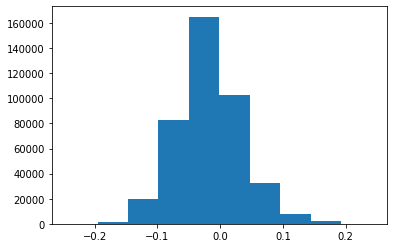

In [42]:
plt.hist((c_mer2018-c_mer2017).flatten())

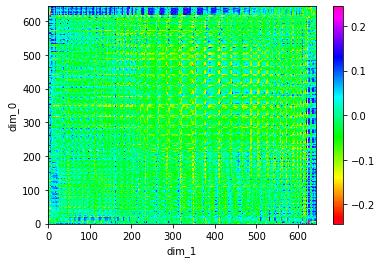

In [43]:
xr.DataArray(c_mer2018-c_mer2017).plot(cmap='gist_rainbow')

## 1 year (2010) vs 1 year (2018)

(array([1.08000e+02, 6.38000e+02, 4.27400e+03, 3.49820e+04, 1.49440e+05,
        1.56786e+05, 5.75040e+04, 1.00760e+04, 8.76000e+02, 5.20000e+01]),
 array([-0.28991787, -0.2317693 , -0.17362072, -0.11547215, -0.05732358,
         0.000825  ,  0.05897357,  0.11712214,  0.17527072,  0.23341929,
         0.29156786]),
 <a list of 10 Patch objects>)

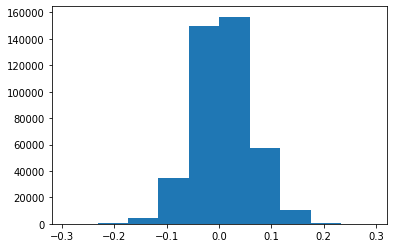

In [44]:
plt.hist((c_mer2018-c_mer2010).flatten())

In [ ]:
xr.DataArray(c_mer2018-c_mer2010).plot(cmap='gist_rainbow')